In [1]:
import json 
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import os
from pathlib import Path
import numpy as np
import torch
from torch.backends import cudnn

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Configuration

In [3]:
EXPERIMENT_NAME = "quick_quick"
SAVE_RESULTS = False
OBJECT_NAME = 'toy_plane'

In [4]:
import torch.utils.model_zoo

MOPED_PATH = Path('/ssd_scratch/cvit/amoghtiwari/latentfusion/data/moped')
LINEMOD_PATH = Path('/ssd_scratch/cvit/amoghtiwari/latentfusion/data/lm_partial')
CHECKPOINT = Path('/ssd_scratch/cvit/amoghtiwari/latentfusion/checkpoints/latentfusion-release.pth')
num_input_views = 1

In [5]:
import sys
sys.path.insert(0,'../')

##########
checkpoint = CHECKPOINT
############

In [6]:
from latentfusion.recon.inference import LatentFusionModel

model = LatentFusionModel.from_checkpoint(checkpoint, device)

2022-07-29 09:25.52 [warning  ] could not import PCL           [latentfusion.pointcloud] 
2022-07-29 09:25.56 [info     ] loaded model                   [latentfusion.recon.inference] epoch=200 name=shapenet,no_mask_morph,fixed_eqlr,256,mask,depth,in_mask,mask_noise_p=0.25,sm=nearest,fuser=gru-branched_20200509_10h19m10s-branched_20200509_10h42m53s-branched_20200509_10h46m53s-branched_20200509_10h48m49s


In [7]:
from latentfusion.recon.inference import Observation
from latentfusion.pose import bop
from latentfusion.datasets.bop import BOPDataset
from latentfusion.datasets.realsense import RealsenseDataset
import latentfusion.visualization as viz
from latentfusion.augment import gan_denormalize
from latentfusion import meshutils
from latentfusion import augment

Adding Anaconda lib path:/home/amoghtiwari/miniconda3/envs/latentfusion/lib/


## Load Dataset

### LINEMOD

Uncomment this and comment out the MOPED cell to use LINEMOD.

In [8]:
# object_id = 4
# frame = 0
# input_scene_path = LINEMOD_PATH / f'train/{object_id:06d}'
# target_scene_path = LINEMOD_PATH / f'test/{object_id:06d}'

# input_dataset = BOPDataset(LINEMOD_PATH, input_scene_path, object_id=object_id, object_scale=None)
# print('object_scale', input_dataset.object_scale)
# target_dataset = BOPDataset(LINEMOD_PATH, target_scene_path, object_id=object_id, object_scale=None)
# object_scale_to_meters = 1.0 / (1000.0 * target_dataset.object_scale)
# pointcloud = input_dataset.load_pointcloud()

### MOPED

In [9]:
object_id = OBJECT_NAME
frame = 100

input_scene_dir = MOPED_PATH / object_id / 'reference'
target_scene_dir = MOPED_PATH / object_id / 'evaluation'

pointcloud_path = input_scene_dir / 'integrated_registered_processed.obj'
obj = meshutils.Object3D(pointcloud_path)
pointcloud = torch.tensor(obj.vertices, dtype=torch.float32)
diameter = obj.bounding_diameter
object_scale = 1.0 / diameter
object_scale_to_meters = 1.0 / object_scale

input_paths = [x for x in input_scene_dir.iterdir() if x.is_dir()]
input_dataset = RealsenseDataset(input_paths,
                                 image_scale=1.0,
                                 object_scale=object_scale,
                                 odometry_type='open3d')
target_paths = sorted([x for x in target_scene_dir.iterdir() if x.is_dir()])
target_dataset = RealsenseDataset(target_paths,
                                  image_scale=1.0,
                                  object_scale=object_scale,
                                  odometry_type='open3d',
                                  use_registration=True)

2022-07-29 09:25.57 [info     ] using registration             [latentfusion.datasets.realsense] path=/ssd_scratch/cvit/amoghtiwari/latentfusion/data/moped/toy_plane/reference/02/registration/registration.json
2022-07-29 09:25.57 [info     ] using registration             [latentfusion.datasets.realsense] path=/ssd_scratch/cvit/amoghtiwari/latentfusion/data/moped/toy_plane/reference/02/registration/registration.json
2022-07-29 09:25.57 [info     ] using registration             [latentfusion.datasets.realsense] path=/ssd_scratch/cvit/amoghtiwari/latentfusion/data/moped/toy_plane/reference/05/registration/registration.json
2022-07-29 09:25.58 [info     ] using registration             [latentfusion.datasets.realsense] path=/ssd_scratch/cvit/amoghtiwari/latentfusion/data/moped/toy_plane/reference/05/registration/registration.json
2022-07-29 09:25.58 [info     ] using registration             [latentfusion.datasets.realsense] path=/ssd_scratch/cvit/amoghtiwari/latentfusion/data/moped/toy_

### Process Dataset into Observations

Here we load the data into the `Observation` class.

**Loading Input Obs**

from latentfusion/observation.py; indices tensor([0])
/ssd_scratch/cvit/amoghtiwari/latentfusion/data/moped/toy_plane/reference/02/color/000000.jpg
/ssd_scratch/cvit/amoghtiwari/latentfusion/data/moped/toy_plane/reference/02/mask/000000.png
/ssd_scratch/cvit/amoghtiwari/latentfusion/data/moped/toy_plane/reference/02/depth/000000.png

\**nLoading Target Obs**

from latentfusion/observation.py; indices [100]
/ssd_scratch/cvit/amoghtiwari/latentfusion/data/moped/toy_plane/evaluation/01/color/000016.jpg
/ssd_scratch/cvit/amoghtiwari/latentfusion/data/moped/toy_plane/evaluation/01/mask/000016.png
/ssd_scratch/cvit/amoghtiwari/latentfusion/data/moped/toy_plane/evaluation/01/depth/000016.png


../latentfusion/modules/geometry.py:352: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1654413022026/work/aten/src/ATen/native/TensorShape.cpp:2890.)
  grids = bboxes_to_grid(boxes, in_size, out_size)


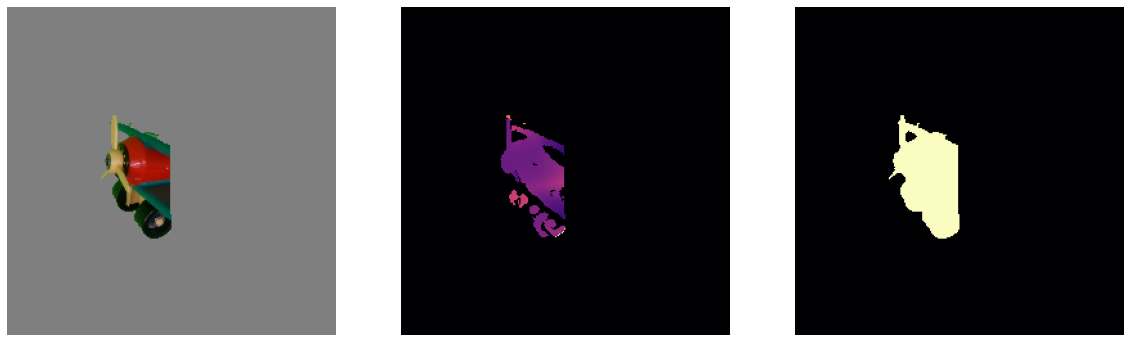

In [10]:
print("**Loading Input Obs**\n")
input_obs = Observation.from_dataset(input_dataset, inds=input_dataset.sample_evenly(num_input_views))

print("\n\**nLoading Target Obs**\n")
target_obs = Observation.from_dataset(target_dataset, inds=list(range(len(target_dataset)))[frame:frame+1])

input_obs_pp = model.preprocess_observation(input_obs)
input_obs_pp_gt = model.preprocess_observation(input_obs)
target_obs_pp = model.preprocess_observation(target_obs)

plt.figure(figsize=(20, 10))
plt.subplot(131)
viz.show_batch(gan_denormalize(input_obs_pp.color), nrow=4)
plt.subplot(132)
viz.show_batch(viz.colorize_depth(input_obs_pp.depth), nrow=4)
plt.subplot(133)
viz.show_batch(viz.colorize_tensor(input_obs_pp.mask), nrow=4)

## Build Latent Object

This builds the 'latent object', referred to as `z_obj` in this code.

recon_error 0.03704099357128143
Time of Building Latent Object is: %d (s) 0.29312872886657715


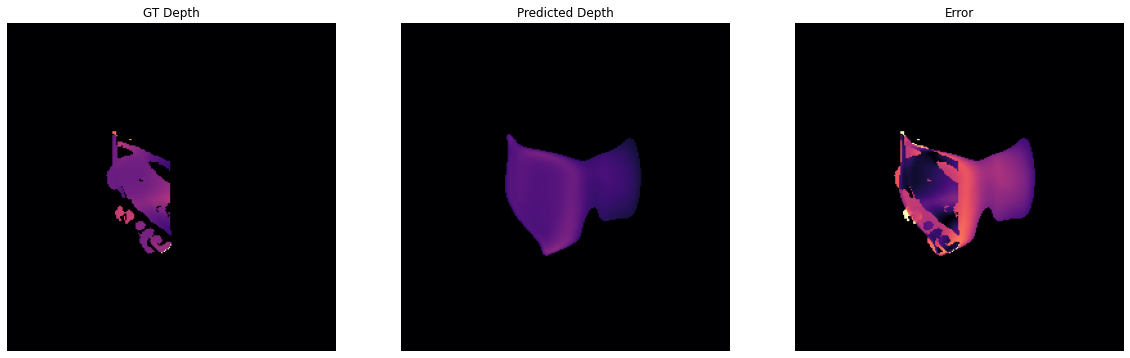

In [11]:
import time
t_start = time.time()

from latentfusion import three
import math

with torch.no_grad():
    z_obj = model.build_latent_object(input_obs_pp)

    # Visualize prediction.
    camera = input_obs_pp.camera.clone()
    y, z = model.render_latent_object(z_obj, camera.to(device))

recon_error = (y['depth'].detach().cpu() - input_obs_pp_gt.depth).abs()
print('recon_error', recon_error.mean().item())
    
plt.figure(figsize=(20, 10))
plt.subplot(131)
viz.show_batch(viz.colorize_depth(input_obs_pp.depth), nrow=4, title='GT Depth')
plt.subplot(132)
viz.show_batch(viz.colorize_depth(y['depth'].detach().cpu()), nrow=4, title='Predicted Depth')
plt.subplot(133)
viz.show_batch(viz.colorize_tensor(recon_error), nrow=4, title='Error')

t_end = time.time()
latent_object_build_time = t_end - t_start
print("Time of Building Latent Object is: %d (s)", latent_object_build_time)

### Visualize some novel views

This visualizes the object from novel views.

In [12]:
# from latentfusion.three.orientation import evenly_distributed_quats
# num_novel = 8
# camera_ref = input_obs.camera[0]
# camera_ref = camera_ref.zoom(None, model.camera_dist, model.input_size)
# quats = evenly_distributed_quats(num_novel, upright=True).to(device)
# camera_test = camera_ref.clone().repeat(num_novel)
# camera_test.quaternion = quats

# with torch.no_grad():
#     y, _ = model.render_ibr_basic(z_obj, input_obs, camera_test.clone().to(device), apply_mask=True)

# plt.figure(figsize=(20, 10))
# plt.subplot(131)
# viz.show_batch(viz.colorize_depth(y['depth']), nrow=4, title='Novel View Depth')
# plt.subplot(132)
# viz.show_batch(gan_denormalize(y['color'].cpu()), nrow=4, title='Novel View Color (IBR)')
# plt.subplot(133)
# viz.show_batch(viz.colorize_tensor(y['mask']), nrow=4, title='Novel View Mask')

## Coarse Pose Estimation

2022-07-29 09:26.07 [info     ] loading pose estimator from config [latentfusion.pose.estimation] init_hemisphere=False init_upright=False learning_rate=0.75 loss_weights={'depth': 1.0, 'ov_depth': 0.0, 'iou': 0.0, 'mask': 0.0} num_elites=48 num_gmm_components=6 num_iters=10 num_samples=128 ranking_size=8 return_camera_history=False sample_flipped=True type=cross_entropy verbose=False


init camera:  Camera(count=1)


2022-07-29 09:26.17 [info     ] best camera                    [latentfusion.pose.estimation] loss=0.07397785037755966 step=9


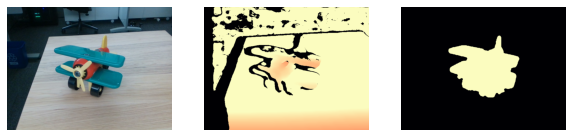

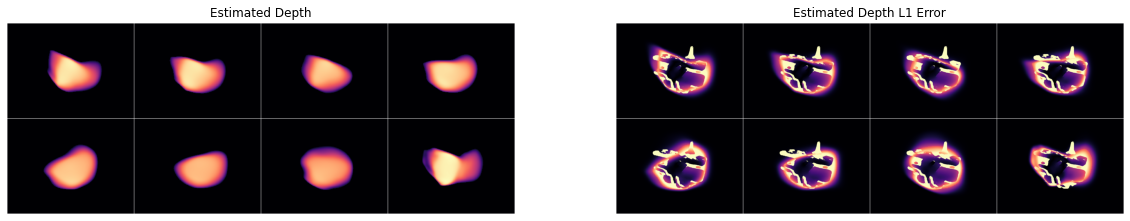

In [13]:
start_t = time.time()

import latentfusion.pose.estimation as pe
from functools import partial

# estimator = pe.load_from_config('../configs/cross_entropy_quick.toml', model, return_camera_history=False, verbose=False)
estimator = pe.load_from_config(f'../configs/cross_entropy_{EXPERIMENT_NAME.split("_")[0]}.toml', model, return_camera_history=False, verbose=False)
coarse_max_num_iters = estimator.num_iters

my_init_camera, coarse_camera = estimator.estimate(z_obj, target_obs[0])
camera_zoom = coarse_camera.zoom(None, model.camera_dist, model.input_size)

# Visualize prediction.
pred_y, pred_z = model.render_latent_object(z_obj, camera_zoom.to(device))
pred_mask = pred_y['mask'].squeeze(0)
pred_depth = pred_y['depth'].squeeze(0)
pred_depth = camera_zoom.denormalize_depth(pred_depth) * pred_mask
pred_depth, _ = camera_zoom.uncrop(pred_depth)
pred_mask, _ = camera_zoom.uncrop(pred_mask)
pred_depth = pred_depth.cpu()
pred_mask = pred_mask.cpu()

end_t = time.time()
coarse_pose_estimation_time = end_t - start_t

plt.figure(1, figsize=(10, 10))
plt.subplot(131)
viz.show_batch(target_obs.color[0], nrow=2)
plt.subplot(132)
viz.show_batch(viz.colorize_tensor(target_obs[0].depth.cpu(), cmin=pred_depth.max()-1, cmax=pred_depth.max()), nrow=2)
plt.subplot(133)
viz.show_batch(viz.colorize_tensor(target_obs.prepare()[0].mask.cpu()), nrow=2)

plt.figure(2, figsize=(20, 10))
plt.subplot(121)
viz.show_batch(viz.colorize_tensor(pred_depth.detach().cpu(), cmin=pred_depth.max()-1, cmax=pred_depth.max()), nrow=4, title="Estimated Depth")

plt.subplot(122)
viz.show_batch(viz.colorize_tensor((target_obs.prepare()[0].depth - pred_depth.detach().cpu()).abs()), nrow=4, title="Estimated Depth L1 Error")

### Fine Pose Estimation

2022-07-29 09:26.18 [info     ] loading pose estimator from config [latentfusion.pose.estimation] converge_patience=10 converge_threshold=1e-06 learning_rate=0.01 loss_weights={'depth': 1.0, 'ov_depth': 0.3, 'iou': 0.0, 'mask': 0.0, 'latent': 0.0} lr_reduce_patience=10 lr_reduce_threshold=0.0001 num_iters=100 num_samples=8 optimizer=adam ranking_size=8 return_camera_history=True track_stats=True type=gradient


2022-07-29 09:26.26 [info     ] convergence patience threshold reached [latentfusion.pose.estimation] count=10 delta=0.0 step=41


2022-07-29 09:26.26 [info     ] best camera                    [latentfusion.pose.estimation] loss=0.12562915682792664 step=31


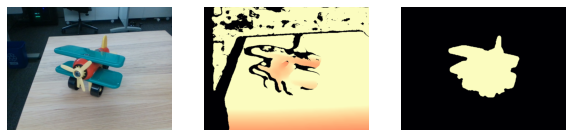

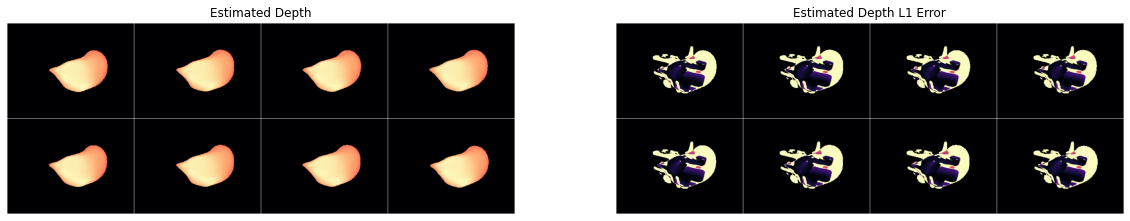

In [14]:
start_t = time.time()

from latentfusion import utils
from latentfusion.pose import utils as pose_utils
from latentfusion.modules.geometry import Camera

# sgd_estimator = pe.load_from_config('../configs/adam_quick.toml', model, track_stats=True, return_camera_history=True, num_iters=100)
sgd_estimator = pe.load_from_config(f'../configs/adam_{EXPERIMENT_NAME.split("_")[1]}.toml', model, track_stats=True, return_camera_history=True, num_iters=100)
fine_max_num_iters = sgd_estimator.num_iters

init_camera = coarse_camera.clone()
refined_camera, stat_history, camera_history = sgd_estimator.estimate(z_obj, target_obs[0], camera=init_camera)
camera_zoom = refined_camera.zoom(None, model.camera_dist, model.input_size)

# Visualize prediction.
pred_y, pred_z = model.render_latent_object(z_obj, camera_zoom.to(device))
pred_mask = pred_y['mask'].squeeze(0)
pred_depth = pred_y['depth'].squeeze(0)
pred_depth = camera_zoom.denormalize_depth(pred_depth) * (pred_y['mask'].squeeze(0) > 0.5)
pred_depth, _ = camera_zoom.uncrop(pred_depth)
pred_mask, _ = camera_zoom.uncrop(pred_mask)
depth_error = (target_obs.prepare()[0].depth - pred_depth.detach().cpu()).abs()
pred_depth = pred_depth.cpu()
pred_mask = pred_mask.cpu()
depth_error = depth_error.cpu()

end_t = time.time()

fine_pose_estimation_time = end_t - start_t

plt.figure(1, figsize=(10, 10))
plt.subplot(131)
viz.show_batch(target_obs.color[0], nrow=2)
plt.subplot(132)
viz.show_batch(viz.colorize_tensor(target_obs[0].depth, cmin=pred_depth.max()-1, cmax=pred_depth.max()), nrow=2)
plt.subplot(133)
viz.show_batch(viz.colorize_tensor(target_obs.prepare()[0].mask), nrow=2)

plt.figure(2, figsize=(20, 10))
plt.subplot(121)
viz.show_batch(viz.colorize_tensor(pred_depth.detach().cpu(), cmin=pred_depth.max()-1, cmax=pred_depth.max()), nrow=4, title="Estimated Depth")

plt.subplot(122)
viz.show_batch(viz.colorize_tensor((target_obs.prepare()[0].depth - pred_depth.detach().cpu()).abs()), nrow=4, title="Estimated Depth L1 Error")

### Show Init Cam Error

In [15]:
from latentfusion.pose.metrics import camera_metrics
from latentfusion.pose.format import metrics_table_multiple

In [16]:
initial_errors_dict_list = []

metrics_table, initial_errors_dict = metrics_table_multiple([
    camera_metrics(target_obs.camera, my_init_camera, pointcloud, object_scale_to_meters)], ['Initial'], tablefmt='simple')

initial_errors_dict_list.append(initial_errors_dict)

print(metrics_table)
print()

initial_rotation_error = []
initial_translation_error = []
initial_add_error = []
initial_add_sym_error = []
initial_add_s_error = []
initial_proj2d_error = []

for errors_dict in initial_errors_dict_list:
    initial_rotation_error.append(float(errors_dict['rotation_error'][0]))
    initial_translation_error.append(float(errors_dict['translation_error'][0]))
    initial_add_error.append(float(errors_dict['add_error'][0]))
    initial_add_sym_error.append(float(errors_dict['add_sym_error'][0]))
    initial_add_s_error.append(float(errors_dict['add_s_error'][0]))
    initial_proj2d_error.append(float(errors_dict['proj2d_error'][0]))

# initial_rotation_error = np.array(initial_rotation_error)
# initial_translation_error = np.array(initial_translation_error)
# initial_add_error = np.array(initial_add_error)
# initial_add_sym_error = np.array(initial_add_sym_error)
# initial_add_s_error = np.array(initial_add_s_error)
# initial_proj2d_error = np.array(initial_proj2d_error)

initial_rotation_error = initial_rotation_error[0]
initial_translation_error = initial_translation_error[0]
initial_add_error = initial_add_error[0]
initial_add_sym_error = initial_add_sym_error[0]
initial_add_s_error = initial_add_s_error[0]
initial_proj2d_error = initial_proj2d_error[0]

           Rotation Error    Translation Error     ADD    ADD (sym)    ADD-S    Proj2D
-------  ----------------  -------------------  ------  -----------  -------  --------
Initial             29.75               0.0501  0.0516       0.0516   0.0202     17.94



In [17]:
# from latentfusion.pose.metrics import camera_metrics
# from latentfusion.pose.format import metrics_table_multiple

# print(metrics_table_multiple([
#     camera_metrics(target_obs.camera, my_init_camera, pointcloud, object_scale_to_meters)], ['Initial'], tablefmt='simple')
# )
# print()

errors_dict_list = []
for j in range(8):
    metrics_table, errors_dict = metrics_table_multiple([
                camera_metrics(target_obs.camera, coarse_camera[j], pointcloud, object_scale_to_meters),
                camera_metrics(target_obs.camera, refined_camera[j], pointcloud, object_scale_to_meters)
        ], ['Coarse', 'Refined'], tablefmt='simple')

    print(metrics_table)
    print()
    errors_dict_list.append(errors_dict)

    #     print(errors_dict)
#     print(metrics_table_multiple([
#             camera_metrics(target_obs.camera, coarse_camera[j], pointcloud, object_scale_to_meters),
#             camera_metrics(target_obs.camera, refined_camera[j], pointcloud, object_scale_to_meters),
#     ], ['Coarse', 'Refined'], tablefmt='simple'))
#     print()

           Rotation Error    Translation Error     ADD    ADD (sym)    ADD-S    Proj2D
-------  ----------------  -------------------  ------  -----------  -------  --------
Coarse              87.64               0.0416  0.0533       0.0533   0.0142     29.82
Refined             76.01               0.0396  0.0486       0.0486   0.013      36.14

           Rotation Error    Translation Error     ADD    ADD (sym)    ADD-S    Proj2D
-------  ----------------  -------------------  ------  -----------  -------  --------
Coarse              87.44               0.0445  0.0546       0.0546   0.0161     30.25
Refined             79.3                0.0394  0.0491       0.0491   0.0129     36.57

           Rotation Error    Translation Error     ADD    ADD (sym)    ADD-S    Proj2D
-------  ----------------  -------------------  ------  -----------  -------  --------
Coarse             104.22               0.0474  0.0604       0.0604   0.0159     33.63
Refined             76.3                0

In [18]:
coarse_rotation_error = []
coarse_translation_error = []
coarse_add_error = []
coarse_add_sym_error = []
coarse_add_s_error = []
coarse_proj2d_error = []

fine_rotation_error = []
fine_translation_error = []
fine_add_error = []
fine_add_sym_error = []
fine_add_s_error = []
fine_proj2d_error = []

for errors_dict in errors_dict_list:
    coarse_rotation_error.append(float(errors_dict['rotation_error'][0]))
    fine_rotation_error.append(float(errors_dict['rotation_error'][1]))
    coarse_translation_error.append(float(errors_dict['translation_error'][0]))
    fine_translation_error.append(float(errors_dict['translation_error'][1]))
    coarse_add_error.append(float(errors_dict['add_error'][0]))
    fine_add_error.append(float(errors_dict['add_error'][1]))
    coarse_add_sym_error.append(float(errors_dict['add_sym_error'][0]))
    fine_add_sym_error.append(float(errors_dict['add_sym_error'][1]))
    coarse_add_s_error.append(float(errors_dict['add_s_error'][0]))
    fine_add_s_error.append(float(errors_dict['add_s_error'][1]))
    coarse_proj2d_error.append(float(errors_dict['proj2d_error'][0]))
    fine_proj2d_error.append(float(errors_dict['proj2d_error'][1]))

coarse_rotation_error = np.array(coarse_rotation_error)
coarse_translation_error = np.array(coarse_translation_error)
coarse_add_error = np.array(coarse_add_error)
coarse_add_sym_error = np.array(coarse_add_sym_error)
coarse_add_s_error = np.array(coarse_add_s_error)
coarse_proj2d_error = np.array(coarse_proj2d_error)

fine_rotation_error = np.array(fine_rotation_error)
fine_translation_error = np.array(fine_translation_error)
fine_add_error = np.array(fine_add_error)
fine_add_sym_error = np.array(fine_add_sym_error)
fine_add_s_error = np.array(fine_add_s_error)
fine_proj2d_error = np.array(fine_proj2d_error)

## My Area

In [19]:
results_dict = {}

results_dict["object_name"] = object_id
results_dict["experiment_name"] = EXPERIMENT_NAME

rotation_error_dict = {"initial": initial_rotation_error, "coarse_avg": np.mean(coarse_rotation_error), "fine_avg": np.mean(fine_rotation_error)}
translation_error_dict = {"initial": initial_translation_error, "coarse_avg": np.mean(coarse_translation_error), "fine_avg": np.mean(fine_translation_error)}
add_error_dict = {"initial": initial_add_error, "coarse_avg": np.mean(coarse_add_error), "fine_avg": np.mean(fine_add_error)}
add_sym_error_dict = {"initial": initial_add_sym_error, "coarse_avg": np.mean(coarse_add_sym_error), "fine_avg": np.mean(fine_add_sym_error)}
add_s_error_dict = {"initial": initial_add_s_error, "coarse_avg": np.mean(coarse_add_s_error), "fine_avg": np.mean(fine_add_s_error)}
proj2d_error_dict = {"initial": initial_proj2d_error, "coarse_avg": np.mean(coarse_proj2d_error), "fine_avg": np.mean(fine_proj2d_error)}

results_dict["rotation_error (deg)"] =  rotation_error_dict
results_dict["translation_error (m)"] =  translation_error_dict
results_dict["add_error (m)"] =  add_error_dict
results_dict["add_sym_error (m)"] =  add_sym_error_dict
results_dict["add_s_error (m)"] =  add_s_error_dict
results_dict["proj2d_error (px)"] =  proj2d_error_dict


In [20]:
# if SAVE_RESULTS:
#     with open(f"../ablations/{object_id}_{EXPERIMENT_NAME}_comparitive.json", "w+") as f:
#         json.dump(results_dict, f, indent=4)

#     with open(f"../ablations/{object_id}_{EXPERIMENT_NAME}_all_errors.json", "w+") as f:
#         f.write("#########\nInitial Error \n##########\n")
#         for item in initial_errors_dict_list:
#             f.write("%s\n" % item)

#         f.write("\n#########\nPost Estimation \n##########\n")
#         for item in errors_dict_list:
#             f.write("%s\n\n" % item)
#     with open(f"../ablations/{object_id}_{EXPERIMENT_NAME}_times.json", "w+") as f:
#         str1 = "Coarse:\n\tTime Taken: %f\n\tMax Num Iterations: %d\n\tNum Samples: %d\n"%(coarse_pose_estimation_time, coarse_max_num_iters, len(coarse_camera.extrinsic))
#         str2 = "Fine:\n\tTime Taken: %f\n\tMax Num Iterations: %d\n\tNum Samples: %d\n"%(fine_pose_estimation_time, fine_max_num_iters, len(refined_camera.extrinsic))
#         str3 = "Latent Object:\n\tBuild Time: %f seconds\n\tNum Input Views: %d\n" % (latent_object_build_time, num_input_views)
#         f.write(str1)
#         f.write(str2)
#         f.write(str3)

In [21]:
# print("Object Name: ", object_id)
# print(initial_rotation_error, np.mean(coarse_rotation_error), np.mean(fine_rotation_error))
# print(initial_translation_error, np.mean(coarse_translation_error), np.mean(fine_translation_error))
# print(initial_add_error, np.mean(coarse_add_error), np.mean(fine_add_error))
# print(initial_add_s_error, np.mean(coarse_add_s_error), np.mean(fine_add_s_error))
# print(initial_add_sym_error, np.mean(coarse_add_sym_error), np.mean(fine_add_sym_error))
# print(initial_proj2d_error, np.mean(coarse_proj2d_error), np.mean(fine_proj2d_error))

### Plot pose refinement stats over time

In [22]:
# import math

# viz.plot_grid(3, figsize=(30, 15), plots=[
#     viz.Plot('Angular Error', [stat_history['angle_dist']/math.pi*180], 
#              params={'ylabel': 'Error (deg)', 'xlabel': 'Iteration'}),
#     viz.Plot('Translation Error', [stat_history['trans_dist']*object_scale_to_meters], 
#              params={'ylabel': 'Error (m)', 'xlabel': 'Iteration'}),
#     viz.Plot('Rank Loss', [stat_history['rank_loss']], 
#              params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
#     viz.Plot('Optim Loss', [stat_history['optim_loss']], 
#              params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
    
#     viz.Plot('Depth Loss', [stat_history['depth_loss']], 
#              params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
#     viz.Plot('Overlap Depth Loss', [stat_history['ov_depth_loss']], 
#              params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
#     viz.Plot('Mask Loss', [stat_history['mask_loss']], 
#              params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
#     viz.Plot('IOU Loss', [stat_history['iou_loss']], 
#              params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
#     viz.Plot('<5 deg <5 cm', [(stat_history['trans_dist']*object_scale_to_meters < 0.05) & (stat_history['angle_dist']/math.pi*180 < 5)], 
#              params={'ylabel': 'Success', 'xlabel': 'Iteration'}),
# ]);